In [27]:
# LSTM Stock Predictor Using Closing Prices

In [28]:
# Data Preparation

In [29]:
import numpy as np
import pandas as pd
import hvplot.pandas

%matplotlib inline

In [30]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [31]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv('btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [32]:
# Load the historical closing prices for bitcoin
df2 = pd.read_csv('btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [33]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [34]:
df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


In [35]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [36]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Try a window size anywhere from 1 to 10 and see how the model performance changes
window_size = 5

# Column index 1 is the `Close` column
feature_column = 1
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [37]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split - 1]
X_test = X[split:]
y_train = y[: split - 1]
y_test = y[split:]

In [38]:
X_train

array([[9114.719727, 8870.820313, 9251.269531, 8218.049805, 6937.080078],
       [8870.820313, 9251.269531, 8218.049805, 6937.080078, 7701.25    ],
       [9251.269531, 8218.049805, 6937.080078, 7701.25    , 7592.720215],
       ...,
       [3652.26001 , 3685.139893, 3611.340088, 3617.409912, 3605.870117],
       [3685.139893, 3611.340088, 3617.409912, 3605.870117, 3588.719971],
       [3611.340088, 3617.409912, 3605.870117, 3588.719971, 3593.48999 ]])

In [39]:
# Use MinMaxScaler to scale the data between 0 and 1. 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [40]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")


X_train sample values:
[[[0.60761794]
  [0.58242373]
  [0.62172321]
  [0.51499412]
  [0.38267307]]

 [[0.58242373]
  [0.62172321]
  [0.51499412]
  [0.38267307]
  [0.46160996]]

 [[0.62172321]
  [0.51499412]
  [0.38267307]
  [0.46160996]
  [0.4503991 ]]

 [[0.51499412]
  [0.38267307]
  [0.46160996]
  [0.4503991 ]
  [0.5193988 ]]

 [[0.38267307]
  [0.46160996]
  [0.4503991 ]
  [0.5193988 ]
  [0.56445096]]] 

X_test sample values:
[[[0.03856719]
  [0.03679562]
  [0.03728835]
  [0.03974167]
  [0.04528668]]

 [[0.03679562]
  [0.03728835]
  [0.03974167]
  [0.04528668]
  [0.04528668]]

 [[0.03728835]
  [0.03974167]
  [0.04528668]
  [0.04528668]
  [0.07024855]]

 [[0.03974167]
  [0.04528668]
  [0.04528668]
  [0.07024855]
  [0.07145402]]

 [[0.04528668]
  [0.04528668]
  [0.07024855]
  [0.07145402]
  [0.07659928]]]


In [41]:
# Build and Train the LSTM RNN

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [43]:
# Build the LSTM RNN model

model = Sequential()

number_units = 10
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [44]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [45]:
# Summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 5, 10)             480       
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 10)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 10)             840       
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 10)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10)                840       
_________________________________________________________________
dropout_5 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [46]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended

model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Train on 374 samples
Epoch 1/10
374/374 [==============================] - 5s 12ms/sample - loss: 0.03834s - loss: 0. - ETA: 2s - loss: 0.06 - ETA: 2s - los - ETA: 0s - loss: 0.04
Epoch 2/10
374/374 [==============================] - 2s 5ms/sample - loss: 0.0247 0s - l - ETA: 0s - loss: 0.025
Epoch 3/10
374/374 [==============================] - 2s 5ms/sample - loss: 0.0222 0s - loss: 
Epoch 4/10
374/374 [==============================] - 2s 6ms/sample - loss: 0.0176 1s - loss - ETA: 1s - l - ETA: 0s - loss: 0.021 - ETA: 0s - loss
Epoch 5/10
374/374 [==============================] - 2s 6ms/sample - loss: 0.0120 1s - loss: 0. - ETA: 1s - loss: 0 - ETA: 1s - loss: 0.02 - ETA: 1s - loss: 0 - ETA: 0s - loss: 0 - ETA: 0s - loss:  - ETA: 0s - loss: 0.012
Epoch 6/10
374/374 [==============================] - 2s 6ms/sample - loss: 0.0109 0s - loss:
Epoch 7/10
374/374 [==============================] - 2s 5ms/sample - loss: 0.0101 1s - loss: 0.02 - ETA: 1s - l - ETA: 0s - loss: 0.01 - ETA: 0s 

In [47]:
# Model Performance

In [48]:
# Evaluate the model
model.evaluate(X_test, y_test)

162/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.04331346468735532

In [49]:
# Make some predictions
predicted = model.predict(X_test)

In [50]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [51]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
})
stocks.head()

,Real,Predicted
0,3670.919922,3684.744141
1,3912.570068,3689.739990
2,3924.239990,3709.917236
3,3974.050049,3744.376221
4,3937.040039,3789.800293


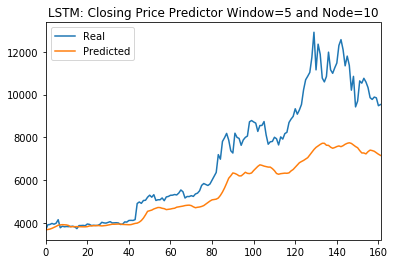

In [53]:
# Plot the real vs predicted values as a line chart
stocks.plot(title='LSTM: Closing Price Predictor Window=5 and Node=10')